## Домашнее задание

Вам нужно написать следующий пайплайн:
1. Получить эмбединги пользователей с помощью SVD.
2. Подать их в нейронную сеть, которую вы делали на практическом занятии.
Она принимает на вход пользователей и эмбединг айтомов, далее объединяет их в два полносвязанных слоя. На последнем слое выдаёт прогноз с функцией активации сигмоид.
3. Обучить сеть.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from pathlib import Path
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot.tf_keras import PlotLossesCallback
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Dense

Подбор оптимального n_factors

In [149]:
data = Dataset.load_builtin('ml-100k')
param_grid = {'n_factors': [2, 5, 10, 15, 20, 30, 40, 50, 70, 100]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs.fit(data)
n_factors = gs.best_params['rmse']['n_factors']
print(
    f"Наименьшая RMSE (при тренировке на полном датасете) достигается при числе факторов {n_factors} и равна: {gs.best_score['rmse']}")

Наименьшая RMSE (при тренировке на полном датасете) достигается при числе факторов 40 и равна: 0.9336376840782423


Загрузка датасета и подготовка данных

In [158]:
df = pd.DataFrame(data.raw_ratings, columns = ['userID', 'itemID', 'rating',  '_']).iloc[:, :-1]
df = df.astype({'userID': 'int64', 'itemID': 'int64', 'rating': 'int64'})
df.head()

,userID,itemID,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [162]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [163]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

Функция подготовки эмбеддингов заданной размерности

In [164]:
def emb_data(df, n_factors):
    X = []
    y = []
    algo = SVD(n_factors=n_factors,random_state=17, verbose=False).fit(trainset)
    for row in df.itertuples():
        user_id = row[1]
        item_id = row[2]
        rating = row[3]
        user_emb = algo.pu[user_id - 1]
        item_emb = algo.qi[item_id - 1]
        X.append(np.concatenate((user_emb, item_emb)))
        if rating > 3:
            y.append(1)
        else:
            y.append(0)
    return np.array(X), np.array(y)


X, y = emb_data(df, n_factors)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Функция создания модели

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               20736     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 53,761
Trainable params: 53,761
Non-trainable params: 0
_______________________________________________________

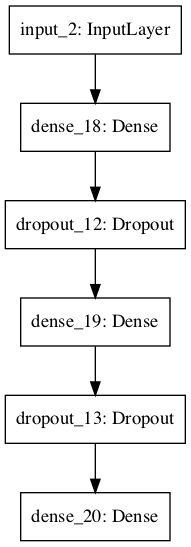

In [168]:
PATH_MYDRIVE = Path('/Users/dev/Рекомендательные системы')
cpt_path = str(PATH_MYDRIVE / 'dz2_checkpoint_best_weights.hdf5')

def get_model(input_dim):

    input = tf.keras.layers.Input(input_dim,)
    layer = tf.keras.layers.Dense(256, activation='relu')(input)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(128, activation='relu')(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(layer)
    
    model = tf.keras.Model(inputs = input, outputs = output)
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=["accuracy"],
                  )
    return model
    
model = get_model(n_factors*2)
early_stopper = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-5)

my_callbacks = [PlotLossesCallback(),
                early_stopper,
                reduce_lr,
                tf.keras.callbacks.ModelCheckpoint(cpt_path,
                                                   monitor='accuracy',
                                                   verbose=1,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   save_freq='epoch',
                                                   mode='max')]  

model.summary()
plot_model(model)

Обучение модели при n_factors = 40

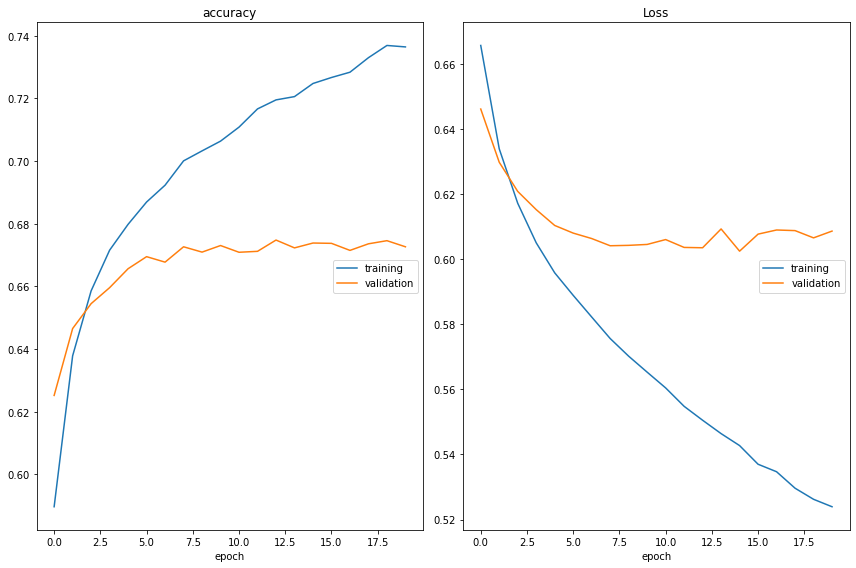

accuracy
	training         	 (min:    0.590, max:    0.737, cur:    0.736)
	validation       	 (min:    0.625, max:    0.675, cur:    0.673)
Loss
	training         	 (min:    0.524, max:    0.666, cur:    0.524)
	validation       	 (min:    0.602, max:    0.646, cur:    0.609)

Epoch 00020: accuracy did not improve from 0.73691


In [169]:
hist = model.fit(X_train, y_train,
    batch_size=128,
    epochs=20,
    shuffle=True,
    validation_data=(X_test, y_test),
    callbacks=my_callbacks)